In [ ]:
# Import libraries
from pyspark.sql import SparkSession
import os

In [ ]:
import sqlite3
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

In [59]:
df = pd.read_csv("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")


In [5]:
# Check for missing values
df.isnull().sum()  

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

In [6]:
# Check number of rows and columns
df.shape

(206144, 11)

In [7]:
# View statistics
df.describe(include="all")

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
count,206144,206144,206144,206144,206144,206144,206144.000000,206144,206144.000000,206144,2.061440e+05
unique,101,26,7,2740,574,17,NaN,21,NaN,687,NaN
top,2024-07,SENGKANG,4 ROOM,2,YISHUN RING RD,04 TO 06,NaN,Model A,NaN,94 years 10 months,NaN
freq,3036,16968,87187,625,2959,47347,NaN,72968,NaN,1857,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,96.896643,NaN,1996.289700,NaN,5.142505e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,24.029185,NaN,14.215699,NaN,1.809886e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,31.000000,NaN,1966.000000,NaN,1.400000e+05
25%,NaN,NaN,NaN,NaN,NaN,NaN,82.000000,NaN,1985.000000,NaN,3.800000e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,93.000000,NaN,1996.000000,NaN,4.820000e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,112.000000,NaN,2011.000000,NaN,6.180000e+05


In [ ]:
# View data types
df.dtypes

# Extract numerical year and month from string and convert to int as dtype of 'month' is object (i.e. 2017-01)
# Extract remaining lease year and month from 'remaining_lease'

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

In [30]:
# View first 10 rows
df.head(10)

# Extract transaction_year and transaction_month from 'month'
# One-hot encoding on 'town'
# Map 'flat_type' and 'storey_range'
# Extract remaining_years and remaining_months from 'month'
# Drop lease_commence_date

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
5,2017-01,ANG MO KIO,3 ROOM,150,ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,63 years,275000.0
6,2017-01,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,61 years 06 months,280000.0
7,2017-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,04 TO 06,67.0,New Generation,1976,58 years 04 months,285000.0
8,2017-01,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,61 years 06 months,285000.0
9,2017-01,ANG MO KIO,3 ROOM,571,ANG MO KIO AVE 3,01 TO 03,67.0,New Generation,1979,61 years 04 months,285000.0


In [31]:
# List unique values of each column
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}' ({len(unique_values)} unique values):")
    print(unique_values)
    print()

# Unique values in 'flat_type' (7 unique values):
['2 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' 'EXECUTIVE' '1 ROOM'
 'MULTI-GENERATION']

# Unique values in 'storey_range' (17 unique values):
['10 TO 12' '01 TO 03' '04 TO 06' '07 TO 09' '13 TO 15' '19 TO 21'
 '22 TO 24' '16 TO 18' '34 TO 36' '28 TO 30' '37 TO 39' '49 TO 51'
 '25 TO 27' '40 TO 42' '31 TO 33' '46 TO 48' '43 TO 45']

# Unique values in 'flat_model' (21 unique values):
['Improved' 'New Generation' 'DBSS' 'Standard' 'Apartment' 'Simplified'
 'Model A' 'Premium Apartment' 'Adjoined flat' 'Model A-Maisonette'
 'Maisonette' 'Type S1' 'Type S2' 'Model A2' 'Terrace'
 'Improved-Maisonette' 'Premium Maisonette' 'Multi Generation'
 'Premium Apartment Loft' '2-room' '3Gen']

# 

Unique values in 'month' (101 unique values):
['2017-01' '2017-02' '2017-03' '2017-04' '2017-05' '2017-06' '2017-07'
 '2017-08' '2017-09' '2017-10' '2017-11' '2017-12' '2018-01' '2018-02'
 '2018-03' '2018-04' '2018-05' '2018-06' '2018-07' '2018-08' '2018-09'
 '2018-10' '2018-11' '2018-12' '2019-01' '2019-02' '2019-03' '2019-04'
 '2019-05' '2019-06' '2019-07' '2019-08' '2019-09' '2019-10' '2019-11'
 '2019-12' '2020-01' '2020-02' '2020-03' '2020-04' '2020-05' '2020-06'
 '2020-07' '2020-08' '2020-09' '2020-10' '2020-11' '2020-12' '2021-01'
 '2021-02' '2021-03' '2021-04' '2021-05' '2021-06' '2021-07' '2021-08'
 '2021-09' '2021-10' '2021-11' '2021-12' '2022-01' '2022-02' '2022-03'
 '2022-04' '2022-05' '2022-06' '2022-07' '2022-08' '2022-09' '2022-10'
 '2022-11' '2022-12' '2023-01' '2023-02' '2023-03' '2023-04' '2023-05'
 '2023-06' '2023-07' '2023-08' '2023-09' '2023-10' '2023-11' '2023-12'
 '2024-02' '2024-04' '2024-06' '2024-09' '2024-11' '2024-12' '2024-01'
 '2024-03' '2024-07' '2024-05' 

['ImprovedNew GenerationDBSSStandardApartmentSimplifiedModel APremium ApartmentAdjoined flatModel A-MaisonetteMaisonetteType S1Type S2Model A2TerraceImproved-MaisonettePremium MaisonetteMulti GenerationPremium Apartment Loft2-room3Gen']

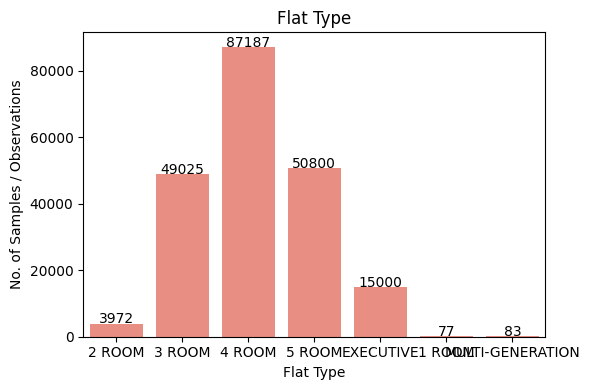

In [13]:
# Distribution of subsription status
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=df['flat_type'], color='salmon')  # assign the plot to ax

plt.title('Flat Type')
plt.xlabel('Flat Type')
plt.ylabel('No. of Samples / Observations')

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 50, f'{int(height)}', ha='center')

plt.tight_layout()
plt.show()

# There is a larger representation of 4 ROOM flat_type in the dataset followed by 5 ROOM and 3 ROOM

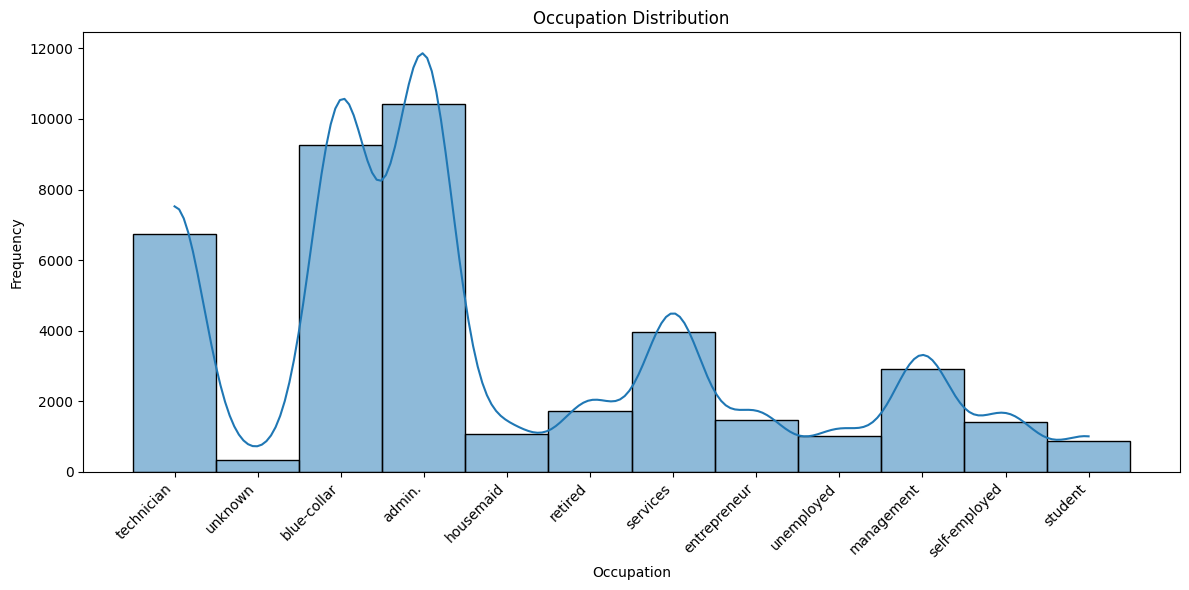

In [92]:
# Distribution of occupation

plt.figure(figsize=(12, 6))
sns.histplot(df['Occupation'], bins=20, kde=True)

plt.title('Occupation Distribution')
plt.xlabel('Occupation')
plt.ylabel('Frequency')

# Rotate x-axis labels to prevent cutoff
plt.xticks(rotation=45, ha='right')

# Prevent clipping of labels
plt.tight_layout()

plt.show()

# Technicians, blue-collar workers and admin workers are more heavily represented in the data set
# Use one-hot encoding to convert categories to binary variables to prevent model from assuming importance of one category over another

In [62]:

df['lease_commence_date'] = df['lease_commence_date'].astype(str).str.extract(r'(\d+)')
df['lease_commence_date'] = df['lease_commence_date'].astype(float).astype('Int64')   


In [56]:
df.dtypes

town                    object
flat_type                int64
block                   object
street_name             object
storey_range             int64
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
transaction_year        object
transaction_month       object
remaining_years        float64
remaining_months       float64
dtype: object

In [60]:
df['block'] = df['block'].astype(str).str.extract(r'(\d+)')
df['block'] = df['block'].astype(float).astype('Int64')   


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time

chrome_options = Options()
chrome_options.add_argument("--headless")  # Run browser in headless mode
driver = webdriver.Chrome(options=chrome_options)

try:
    driver.get("https://www.singpost.com/find-postal-code")  # Replace with the actual URL

    # Wait for the page to load (adjust time or use explicit waits)
    time.sleep(3)

    # Find Block input field by XPath and enter the block number
    block_input = driver.find_element(By.XPATH, '//*[@id="edit-building-no"]')
    block_input.clear()
    block_input.send_keys("510")  # example block

    # Similarly, find Street Name input, e.g. by its XPath or ID, and enter street name
    # Example placeholder, replace with actual XPath or ID
    street_input = driver.find_element(By.XPATH, '//*[@id="edit-street-name"]')  # Replace with actual ID or XPath
    street_input.clear()
    street_input.send_keys("Pasir Ris Street 52")

    # Submit the form or click Search button
    search_button = driver.find_element(By.XPATH, '//*[@id="edit-submit"]')  # Replace with actual button ID or XPath
    search_button.click()

    # Wait for results to load
    time.sleep(3)

    # Extract postal code from result using XPath or CSS selector
    postal_code_element = driver.find_element(By.XPATH, '//*[@id="fpc-street-node"]/div/div/div/div/p')  # Replace with actual XPath
    postal_code = postal_code_element.text
    print("Postal code:", postal_code)

finally:
    driver.quit()


In [ ]:
# Unique values in 'flat_type' (7 unique values):
#['2 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' 'EXECUTIVE' '1 ROOM'
# 'MULTI-GENERATION']

# Mapping for feature 'flat_type'
# Executive flats are generally larger than 5-room flats and often include a study area or balcony. 
# 3Gen flats are specifically for multi-generational families, featuring four bedrooms and three bathrooms
# including two master bedrooms with attached

def flat_type_mapping(str):
    if str == '1 ROOM':
        return 1
    elif str == '2 ROOM':
        return 2
    elif str == '3 ROOM':
        return 3
    elif str == '4 ROOM':
        return 4
    elif str == '5 ROOM':
        return 5
    elif str == 'EXECUTIVE':
        return 6
    elif str == 'MULTI-GENERATION':
        return 7

# Unique values in 'storey_range' (17 unique values):
#['10 TO 12' '01 TO 03' '04 TO 06' '07 TO 09' '13 TO 15' '19 TO 21'
# '22 TO 24' '16 TO 18' '34 TO 36' '28 TO 30' '37 TO 39' '49 TO 51'
# '25 TO 27' '40 TO 42' '31 TO 33' '46 TO 48' '43 TO 45']

def storey_range_mapping(str):
    if str == '01 TO 03':
        return 1
    elif str == '04 TO 06':
        return 2
    elif str == '07 TO 09':
        return 3
    elif str == '10 TO 12':
        return 4
    elif str == '13 TO 15':
        return 5
    elif str == '16 TO 18':
        return 6
    elif str == '19 TO 21':
        return 7
    elif str == '22 TO 24':
        return 8
    elif str == '25 TO 27':
        return 9
    elif str == '28 TO 30':
        return 10
    elif str == '31 TO 33':
        return 11
    elif str == '34 TO 36':
        return 12
    elif str == '37 TO 39':
        return 13
    elif str == '40 TO 42':
        return 14
    elif str == '43 TO 45':
        return 15
    elif str == '46 TO 48':
        return 16
    elif str == '49 TO 51':
        return 17

# Unique values in 'flat_model' (21 unique values):
#['Improved' 'New Generation' 'DBSS' 'Standard' 'Apartment' 'Simplified'
# 'Model A' 'Premium Apartment' 'Adjoined flat' 'Model A-Maisonette'
# 'Maisonette' 'Type S1' 'Type S2' 'Model A2' 'Terrace'
# 'Improved-Maisonette' 'Premium Maisonette' 'Multi Generation'
# 'Premium Apartment Loft' '2-room' '3Gen']

# Extract 'transaction_year' and 'transaction_month' from 'month'
def extract_transaction_year_month(value):
    match = re.match(r'(\d+)\s+years?\s+(\d+)\s+months?', value)
    if match:
        return int(match.group(1)), int(match.group(2))
    else:
        return None, None

# Extract 'remaining_year' and 'remaining_months' from 'remaining_lease'
def extract_remaining_years_months(value):
    match = re.match(r'(\d+)\s+years?\s+(\d+)\s+months?', value)
    if match:
        return int(match.group(1)), int(match.group(2))
    else:
        return None, None

# Apply functions to features
df['transaction_year'], df['transaction_month'] = zip(*df['month'].apply(extract_transaction_year_month))
df['flat_type'] = df['flat_type'].apply(flat_type_mapping)
df['storey_range'] = df['storey_range'].apply(storey_range_mapping)
#df['remaining_years'], df['remaining_months'] = zip(*df['remaining_lease'].apply(extract_remaining_years_months))

# One-hot encoding to features 'town', 'flat_model'
df = pd.get_dummies(df, columns=['town'], prefix='town')
df = pd.get_dummies(df, columns=['flat_model'], prefix='model')

# Drop feature 'marital_status_single' to avoid perfect correlation (not married not divorced = single)
# Drop feature 'contact_method_telphone' to avoid perfect correlation (not telephone = cellular)

# Drop features after extraction
#df = df.drop(['month', 'remaining_lease'], axis=1)

In [63]:
# Compute correlations and store in variable 'corr_df'
corr_df = df.corr(numeric_only=True)

# Plot heatmap
fig = px.imshow(corr_df, text_auto=True, color_continuous_scale='RdBu_r', aspect="auto")
fig.update_layout(title="Correlation Heatmap", xaxis_title="Features", yaxis_title="Features")
fig.update_xaxes(side="top")
fig.show()

# There seems to be a correlation between 'Subscription Status' and 'Client ID'

In [ ]:
df.describe().T

# 

,count,mean,std,min,25%,50%,75%,max
flat_type,206144.0,4.115691,0.919774,1.0,3.0,4.0,5.0,7.0
storey_range,206144.0,3.253206,1.979159,1.0,2.0,3.0,4.0,17.0
floor_area_sqm,206144.0,96.896643,24.029185,31.0,82.0,93.0,112.0,366.7
lease_commence_date,206144.0,1996.289700,14.215699,1966.0,1985.0,1996.0,2011.0,2021.0
resale_price,206144.0,514250.537977,180988.642001,140000.0,380000.0,482000.0,618000.0,1600000.0
